<a href="https://colab.research.google.com/github/Meridor6919/BeeClassification/blob/master/BeeClassification_RESNET_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:

import keras
from keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras import datasets, layers, models, losses
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ataset = tfds.load('bee_dataset', split=['train'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/7490 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/bee_dataset/bee_dataset_300/1.0.0.incompleteWQSGS7/bee_dataset-train.tfrecord*…

Dataset bee_dataset downloaded and prepared to ~/tensorflow_datasets/bee_dataset/bee_dataset_300/1.0.0. Subsequent calls will reuse this data.


In [3]:
#Split between training data, validation data, test data
splitSize = (0.0, 0.765, 0.9, 1.0)

Testing precision on red channel only

In [4]:
array = np.vstack(tfds.as_numpy(dataset[0]))
ranges = list([int(array.shape[0] * x) for x in splitSize])

def getDataset(ranges, idx):
    return (
        np.array(list(map(lambda x: x[0][:, :, :], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['cooling_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['pollen_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['varroa_output'], array[ranges[idx]: ranges[idx + 1]]))),
        np.array(list(map(lambda x: x[1]['wasps_output'], array[ranges[idx]: ranges[idx + 1]])))
    )
train_images, train_labels1,train_labels2,train_labels3, train_labels4= getDataset(ranges, 0)
validation_images, validation_labels1,validation_labels2, validation_labels3, validation_labels4 = getDataset(ranges, 1)
test_images, test_labels1,test_labels2,test_labels3, test_labels4  = getDataset(ranges, 2)

<ipython-input-4-621227d31954>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  array = np.vstack(tfds.as_numpy(dataset[0]))
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [ ]:
array = np.vstack(tfds.as_numpy(dataset[0]))
ranges = list([int(array.shape[0] * x) for x in splitSize])

def getDataset(ranges, idx):
  return ( 
      np.array(list(map(lambda x: x[0][:, :, :], array[ranges[idx] : ranges[idx+1]]))),
      np.array(list(map(lambda x: x[1]['cooling_output'], array[ranges[idx] : ranges[idx+1]])))
      )

train_images, train_labels = getDataset(ranges, 0)
validation_images, validation_labels = getDataset(ranges, 1)
test_images, test_labels = getDataset(ranges, 2)

<ipython-input-4-14b51f081e4a>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  array = np.vstack(tfds.as_numpy(dataset[0]))
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [ ]:

train_labels[:22]

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [5]:
train_labels = np.dstack((train_labels1, train_labels2, train_labels3,train_labels4)).squeeze()
validation_labels = np.dstack((validation_labels1,validation_labels2, validation_labels3, validation_labels4)).squeeze()
test_labels = np.dstack((test_labels1,test_labels2,test_labels3, test_labels4)).squeeze()
train_labels.shape, train_labels[:10]

((5729, 4), array([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]))

In [6]:
def identity_block(x, filter):
    x_skip = x
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [7]:
def convolutional_block(x, filter):
    x_skip = x
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:

def AlexNet(shape = (300,150, 3), classes =4):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.Rescaling(1./255)(x_input)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x)
    x = tf.keras.layers.Conv2D(96, 11, strides=4, padding='same'))(x)
    x = tf.keras.layers.Lambda(tf.nn.local_response_normalization))(x)
    x = tf.keras.layers.Activation('relu'))(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2))(x)
    x = tf.keras.layers.Conv2D(256, 5, strides=4, padding='same'))(x)
    x = tf.keras.layers.Lambda(tf.nn.local_response_normalization))(x)
    x = tf.keras.layers.Activation('relu'))(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2))(x)
    x = tf.keras.layers.Conv2D(384, 3, strides=4, padding='same'))(x)
    x = tf.keras.layers.Activation('relu'))(x)
    x = tf.keras.layers.Conv2D(384, 3, strides=4, padding='same'))(x)
    x = tf.keras.layers.Activation('relu'))(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=4, padding='same'))(x)
    x = tf.keras.layers.Activation('relu'))(x)
    x = tf.keras.layers.Flatten())(x)
    x = tf.keras.layers.Dense(4096, activation='relu'))(x)
    x = tf.keras.layers.Dropout(0.5))(x)
    x = tf.keras.layers.Dense(4096, activation='relu'))(x)
    x = tf.keras.layers.Dropout(0.5))(x)
    x = tf.keras.layers.Dense(10, activation='softmax'))(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model
def ResNet34(shape = (300,150, 3), classes =4):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.Rescaling(1./255)(x_input)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [13]:
def ResNet34(shape = (300,150, 3), classes =4):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.Rescaling(1./255)(x_input)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [14]:
model = ResNet34()

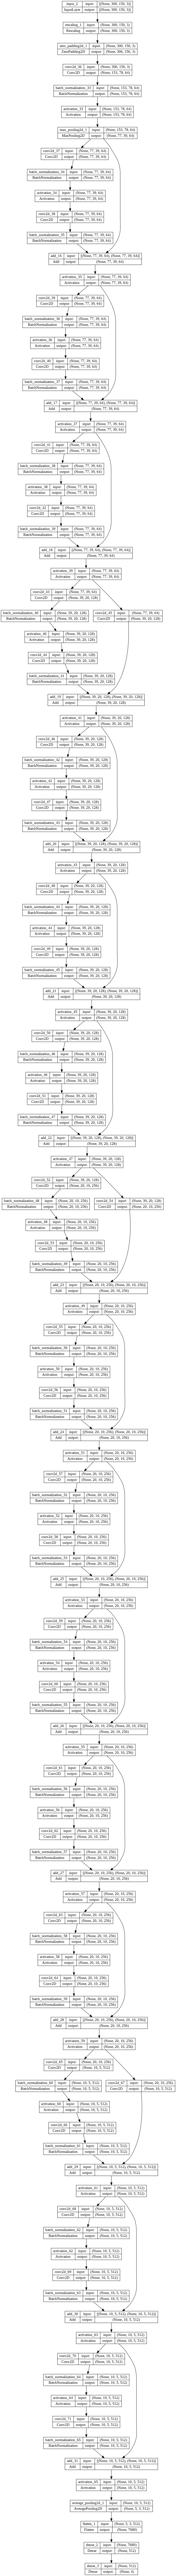

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


In [16]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.time_started = None
        self.time_finished = None
        self.time_curr_epoch = None
        self.num_epochs = 0
        self._loss, self._acc, self._val_loss, self._val_acc = [], [], [], []
        
    def _plot_model_performance(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Model performance', size=20)
        
        ax1.plot(range(self.num_epochs), self._loss, label='Training loss')
        ax1.plot(range(self.num_epochs), self._val_loss, label='Validation loss')
        ax1.set_xlabel('Epoch', size=14)
        ax1.set_ylabel('Loss', size=14)
        ax1.legend()
        
        ax2.plot(range(self.num_epochs), self._acc, label='Training accuracy')
        ax2.plot(range(self.num_epochs), self._val_acc, label='Validation Accuracy')
        ax2.set_xlabel('Epoch', size=14)
        ax2.set_ylabel('Accuracy', size=14)
        ax2.legend()
        
    def on_train_begin(self, logs=None):
        self.time_started = datetime.now()
        print(f'TRAINING STARTED | {self.time_started}\n')
        
    def on_train_end(self, logs=None):
        self.time_finished = datetime.now()
        train_duration = str(self.time_finished - self.time_started)
        print(f'\nTRAINING FINISHED | {self.time_finished} | Duration: {train_duration}')
        
        tl = f"Training loss:       {logs['loss']:.5f}"
        ta = f"Training accuracy:   {logs['accuracy']:.5f}"
        vl = f"Validation loss:     {logs['val_loss']:.5f}"
        va = f"Validation accuracy: {logs['val_accuracy']:.5f}"
        
        print('\n'.join([tl, vl, ta, va]))
        self._plot_model_performance()
        
    def on_epoch_begin(self, epoch, logs=None):
        self.time_curr_epoch = datetime.now()
        
    def on_epoch_end(self, epoch, logs=None):
        self.num_epochs += 1
        epoch_dur = (datetime.now() - self.time_curr_epoch).total_seconds()
        tl = logs['loss']
        ta = logs['accuracy']
        vl = logs['val_loss']
        va = logs['val_accuracy']
        
        self._loss.append(tl); self._acc.append(ta); self._val_loss.append(vl); self._val_acc.append(va)
        
        train_metrics = f"train_loss: {tl:.5f}, train_accuracy: {ta:.5f}"
        valid_metrics = f"valid_loss: {vl:.5f}, valid_accuracy: {va:.5f}"
        
        print(f"Epoch: {epoch:4} | Runtime: {epoch_dur:.3f}s | {train_metrics} | {valid_metrics}")

In [18]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history = model.fit(train_images, train_labels,
                        epochs=100,
                        batch_size = 32,
                    callbacks=[MyCallback()],
                        validation_data=(validation_images, validation_labels))

TRAINING STARTED | 2022-12-21 08:54:56.040006

Epoch 1/100
  6/180 [>.............................] - ETA: 31s - loss: 4.0607 - accuracy: 0.3542

180/180 [==============================] - 40s 202ms/step - loss: 0.4994 - accuracy: 0.4161 - val_loss: 0.6464 - val_accuracy: 0.1294
Epoch 2/100
180/180 [==============================] - 34s 191ms/step - loss: 0.1821 - accuracy: 0.5395 - val_loss: 1.2509 - val_accuracy: 0.2460
Epoch 3/100
180/180 [==============================] - 34s 192ms/step - loss: 0.1435 - accuracy: 0.5446 - val_loss: 0.3981 - val_accuracy: 0.4239
Epoch 4/100
180/180 [==============================] - 35s 192ms/step - loss: 0.1271 - accuracy: 0.5523 - val_loss: 1.9331 - val_accuracy: 0.2747
Epoch 5/100
180/180 [==============================] - 34s 191ms/step - loss: 0.1133 - accuracy: 0.5547 - val_loss: 0.5000 - val_accuracy: 0.4032
Epoch 6/100
180/180 [==============================] - 34s 192ms/step - loss: 0.0746 - accuracy: 0.5701 - val_loss: 0.0747 - val_accuracy: 0.5949
Epoch 7/100
180/180 [==============================] - 35s 196ms/step - loss: 0.0332 - accuracy: 0.5867 - val_loss: 1.6542 - val_accurac

NameError: ignored

In [22]:
model.evaluate(test_images, test_labels)

24/24 [==============================] - 2s 71ms/step - loss: 0.1085 - accuracy: 0.6716


[0.10847102105617523, 0.6715620756149292]

# **loss: 0.1085 - accuracy: 0.6716**
